# **Classificazione Dati Mono-Dimensionale**

- Veronica Morelli
- Aurora Cerabolini

https://urbansounddataset.weebly.com/urbansound8k.html 

Il set di dati è costituito da un insieme di tracce audio classificati in 10 categorie:

-	*air_conditioner*: aria Condizionata
-	*car_horn*: auto
-	*children_playing*: bambini che giocano
-	*dog_bark*: abbaio del cane
-	*drilling*: foratura/trivellazione
-	*enginge_idling*: motore acceso al minimo
-	*gun_shot*: sparo di pistola
-	*jackhammer*: martello pneumatico
-	*siren*: sirene
-	*street_music*: musica di strada


Questa sezione serve a configurare l'ambiente, importare le librerie utili e impostare le directory:

In [ ]:
# Import useful libraries
import os
import glob
import zipfile
import shutil
from shutil import copyfile
import numpy as np
import pandas as pd
from time import time
from scipy.io import wavfile as wav
import shutil
from shutil import copyfile

import random 
from random import seed
from random import random

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only
import seaborn as sns

# Audio management and processing
import librosa
from librosa.feature import melspectrogram

# Image management
import cv2

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical 
from keras.models import load_model

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [ ]:
# Mount GDrive
drive.mount('/content/gdrive/', force_remount = True) 

Mounted at /content/gdrive/


## **1) Caricamento e Organizzazione Dati**

Inizialmente i dati sono stati caricati su drive in un file zip UrbanSound8K. Il file zip è diviso in 10 fold contenenti all'interno un numero variabile di tracce audio di classi diverse. 

In questa sezione si organizzano i dati in modo differente, creando una nuova cartella UrbanSound8K_fin contenente 10 cartelle contenenti ognuna file di una classe specifica. Le 10 cartelle sono nominate con i nomi delle 10 classi, all'interno sono contenenti tracce audio appartenenti solo a quella classe. 

In [ ]:
t0 = time()

copyfile('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K.zip', 'UrbanSound8K.zip')

zip = zipfile.ZipFile('UrbanSound8K.zip')
zip.extractall()
zip.close()

print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 160.300 seconds


Ora in '/content/' path ci sono 10 cartelle, da fold1 a fold10. <br>
Riorganizziamo i dati creando una 'Dati' contenente una nuova cartella UrbanSound8K_fin nel quale gli audio verranno organizzati in base alla loro classe. In UrbanSound8K_fin ci saranno 10 cartelle, ognuna corrispondente ad una classe. In ogni cartella ci saranno gli audio appartenenti a quella classe.

In [ ]:
diz_classID = {'0': 'air_conditioner',
               '1': 'car_horn',
               '2': 'children_playing',
               '3': 'dog_bark',
               '4': 'drilling',
               '5': 'enginge_idling',
               '6': 'gun_shot',
               '7': 'jackhammer',
               '8': 'siren',
               '9': 'street_music'}

In [ ]:
# source
def path_fold(fold):
  main_srcdir = '/content/fold' + str(fold) + '/' 
  return main_srcdir

In [ ]:
path_fold(1)

'/content/fold1/'

In [ ]:
# Destination
main_dstdir = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'

In [ ]:
for fold in range(1,11): # for sulle fold
 
 src_dir = path_fold(fold)
 
 for audio in os.listdir(src_dir):  # for sui file delle fold
   
   classID = audio[0:(len(audio)-4)].split('-')[1] # estrae l'identificativo della classe
   className = diz_classID[classID] # nome della classe
   
   dir = src_dir + audio
   dst = main_dstdir + className + '/'
   dst_audio = dst + audio
   
   if (os.path.exists(dst)): # se la cartella esiste --> aggiungi il file
    shutil.copyfile(dir, dst_audio)
  
   if not os.path.exists(dst): # se la cartella non esiste --> creala --> aggiungi il file
    os.makedirs(dst)
    shutil.copyfile(dir, dst_audio)

### **2.1) Campionamento casuale 100 audio per classe**

Prima di procedere nelle fasi successive è stato creato un dataset aggiuntivo contenente 100 audio per ogni classe.

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'

In [ ]:
dst_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_reduced/'

In [ ]:
index_list = []
for i in range(100):
  index_list.append(i) 

In [ ]:
type(index_list[0])

int

In [ ]:
for fold in os.listdir(base_path):

  src_path = base_path + fold + '/'

  for i, audio in enumerate(os.listdir(src_path)):

    dir = src_path + audio
    dst = dst_path + fold + '/' 
    dst_audio = dst + audio

    if i in index_list:

      if (os.path.exists(dst)): # se la cartella esiste --> aggiungi il file
        shutil.copyfile(dir, dst_audio)

      if not os.path.exists(dst): # se la cartella non esiste --> creala --> aggiungi il file
        os.makedirs(dst)
        shutil.copyfile(dir, dst_audio)


## 2) **EDA**: Explanatory Data Analysis

Prima di entrare nel vivo della fase di modellazione, viene eseguita un'analisi esplorativa per capire come si presenta il dataset.

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'

In [ ]:
# Classi
sound_classes = os.listdir(base_path)
sound_classes

['dog_bark',
 'drilling',
 'jackhammer',
 'street_music',
 'children_playing',
 'enginge_idling',
 'siren',
 'gun_shot',
 'air_conditioner',
 'car_horn']

### 2.1) **Conteggio numero audio per classe**

#### 2.1.1) **Dataset originale**

In [ ]:
diz_classenum = {}
for classe in os.listdir(base_path_reduced):
  dir = base_path + classe + '/'
  num_audio = 0
  cat = classe
  for audio in os.listdir(dir):
    num_audio +=1  
  diz_classenum[cat] = int(num_audio)

In [ ]:
df = pd.DataFrame({'Classe': diz_classenum.keys(),
                   'Numero Audio': diz_classenum.values()})
df = df.sort_values('Numero Audio', ascending=False)

In [ ]:
df

,Classe,Numero Audio
0,dog_bark,1000
1,drilling,1000
2,jackhammer,1000
3,street_music,1000
4,children_playing,1000
5,enginge_idling,1000
8,air_conditioner,1000
6,siren,929
9,car_horn,429
7,gun_shot,374


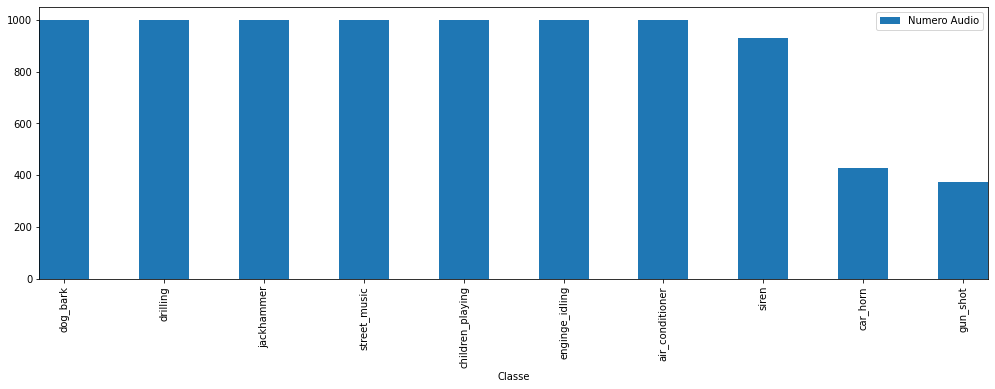

In [ ]:
ax = df.plot.bar(x='Classe',y='Numero Audio',figsize=(17, 5))
ax.autoscale(axis='x',tight=True);

#### 2.1.2) **Dataset campionato**

In [ ]:
diz_classenum_reduced = {}
for classe in os.listdir(base_path_reduced):
  dir = base_path_reduced + classe + '/'
  num_audio = 0
  cat = classe
  for audio in os.listdir(dir):
    num_audio +=1  
  diz_classenum_reduced[cat] = int(num_audio)

In [ ]:
df = pd.DataFrame({'Classe': diz_classenum_reduced.keys(),
                   'Numero Audio': diz_classenum_reduced.values()})
df = df.sort_values('Numero Audio', ascending=False)

In [ ]:
df

,Classe,Numero Audio
0,dog_bark,100
1,drilling,100
2,jackhammer,100
3,street_music,100
4,children_playing,100
5,enginge_idling,100
6,siren,100
7,gun_shot,100
8,air_conditioner,100
9,car_horn,100


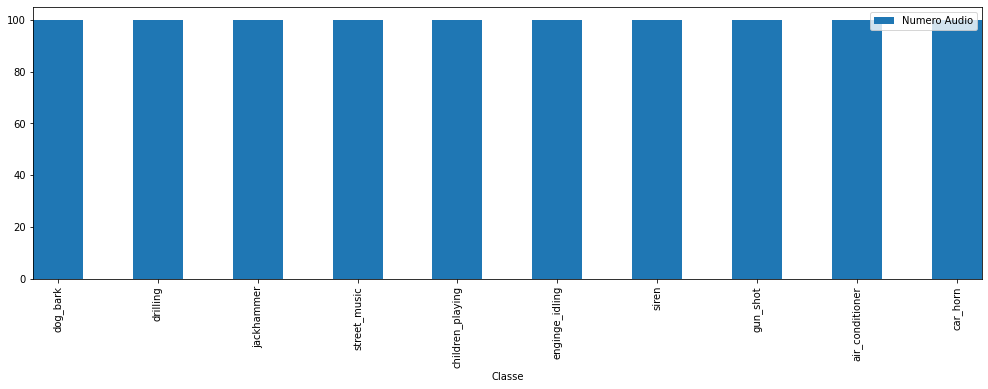

In [ ]:
ax = df.plot.bar(x='Classe',y='Numero Audio',figsize=(17, 5))
ax.autoscale(axis='x',tight=True);

### 2.2) **Visualizzazioni Audio**

In [ ]:
diz_audio1 = {}
diz_audio2 = {}
import random
random.seed(1234)
for classe in os.listdir(base_path):
  dir = base_path + classe + '/'
  audio = random.choice(os.listdir(dir))
  dir_audio = dir + audio
  diz_audio1[classe] = audio
  diz_audio2[classe] = dir_audio

In [ ]:
diz_audio1

{'dog_bark': '196127-3-0-0.wav',
 'drilling': '161129-4-0-10.wav',
 'jackhammer': '22883-7-10-0.wav',
 'street_music': '60605-9-0-90.wav',
 'children_playing': '160009-2-0-11.wav',
 'enginge_idling': '103258-5-0-5.wav',
 'siren': '66601-8-0-1.wav',
 'gun_shot': '145206-6-4-0.wav',
 'air_conditioner': '177621-0-0-0.wav',
 'car_horn': '83465-1-0-0.wav'}

In [ ]:
diz_audio2

{'dog_bark': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/dog_bark/196127-3-0-0.wav',
 'drilling': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/drilling/161129-4-0-10.wav',
 'jackhammer': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/jackhammer/22883-7-10-0.wav',
 'street_music': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/street_music/60605-9-0-90.wav',
 'children_playing': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/children_playing/160009-2-0-11.wav',
 'enginge_idling': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/enginge_idling/103258-5-0-5.wav',
 'siren': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/siren/66601-8-0-1.wav',
 'gun_shot': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/gun_shot/145206-6-4-0.wav',
 'air_conditioner': '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSI

In [ ]:
for classe in diz_audio2:
  path_audio = diz_audio2[classe]
  audio_name = path_audio.split('/')[8]
  sd, sr = librosa.load(path_audio, sr=None)
  print(f'{audio_name} sound rate: {sr}, sound data shape: {sd.shape}' )

196127-3-0-0.wav sound rate: 48000, sound data shape: (192000,)
161129-4-0-10.wav sound rate: 192000, sound data shape: (768000,)
22883-7-10-0.wav sound rate: 48000, sound data shape: (110880,)
60605-9-0-90.wav sound rate: 44100, sound data shape: (176400,)
160009-2-0-11.wav sound rate: 44100, sound data shape: (176400,)
103258-5-0-5.wav sound rate: 48000, sound data shape: (192000,)
66601-8-0-1.wav sound rate: 44100, sound data shape: (176400,)
145206-6-4-0.wav sound rate: 44100, sound data shape: (42658,)
177621-0-0-0.wav sound rate: 48000, sound data shape: (192000,)
83465-1-0-0.wav sound rate: 44100, sound data shape: (22932,)


Sound rate e Sound data variabile da audio a audio.

In [ ]:
path_audio = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/dog_bark/196127-3-0-0.wav'

In [ ]:
sd, sr = librosa.load(path_audio, sr=None)
print(f'Sound data of audio 196127-3-0-0.wav is: {sd.shape}')
print(f'Sound rate of audio 196127-3-0-0.wav is: {sr}')

Sound data of audio 196127-3-0-0.wav is: (192000,)
Sound rate of audio 196127-3-0-0.wav is: 48000


#### 2.2.1) Temporal Representation

In [ ]:
[sound_rate, sound_data] = wav.read(path_audio)

In [ ]:
ipd.Audio(sd, rate=sr)

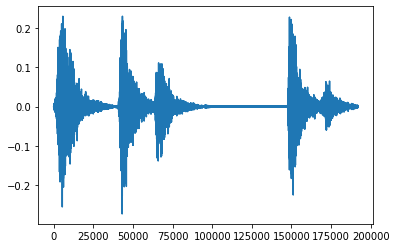

In [ ]:
plt.plot(sd)

Voglio fare una rappresentazione temporale del segnale. <br>
Per la traccia audio, la frequenza di riproduzione è 48000 e la dimensione è di 192000 campioni. Voglio calcolare la durata della traccia in secondi. In questo caso 48000 corrisponde a 1 secondo, di conseguenza la traccia audio dura circa 4 secondi. 

In [ ]:
# Durata
sound_time = np.arange(sd.shape[0])*1.0/sr
sound_time

array([0.00000000e+00, 2.08333333e-05, 4.16666667e-05, ...,
       3.99993750e+00, 3.99995833e+00, 3.99997917e+00])

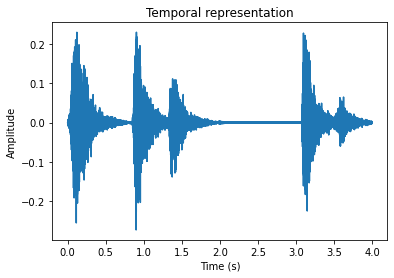

In [ ]:
# Visualizing a signal (temporal representation)
plt.plot(sound_time, sd);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

#### 2.2.2) Frequency representation (Fast Fourier Trasformation)

In [ ]:
sound_rfft = rfft(sd)
sound_rfreqs = rfftfreq(len(sd), 1.0/sr)

In [ ]:
sound_rfft.shape

(96001,)

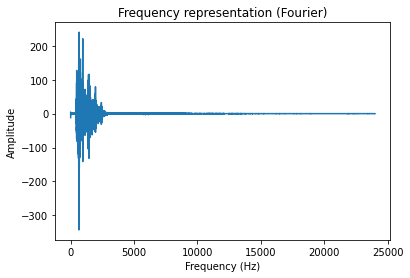

In [ ]:
# Visualizing the frequency signal
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

#### 2.2.3) Temporal/Frequency representation (Spectrogram)

Lo spettrogramma viene calcolato dividendo la traccia audio in segmenti e calcolando la trasformazione di Fourier individualmente per ogni segmento (invece di una volta sull'intera traccia). Per ogni segmento di tempo (colonna), hai la sua descrizione di Fourier (righe).

In [ ]:
[spec_freqs, spec_times, spec] = spectrogram(sd, fs=sr) 

In [ ]:
spec.shape

(129, 857)

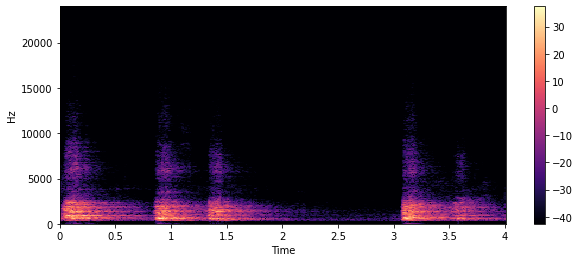

In [ ]:
# Spectrogram visualization
sig_stft = librosa.stft(sd)
sig_db = librosa.amplitude_to_db(abs(sig_stft))
plt.figure(figsize=(10, 4))
librosa.display.specshow(sig_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### 2.2.4) Temporal/Frequency representation (Mel Spectrogram)




Lo spettrogramma Mel tiene conto del fatto che gli esseri umani non percepiscono le frequenze in modo lineare. Viene definito ridistribuendo le frequenze Hertz in frequenze Mel mediante un'appropriata moltiplicazione matriciale. 

In [ ]:
# Mel spectrogram computation (with default parameters)
mel = melspectrogram(y=sd*1.0, sr=sr)

In [ ]:
mel.shape

(128, 376)

In [ ]:
type(mel)

numpy.ndarray

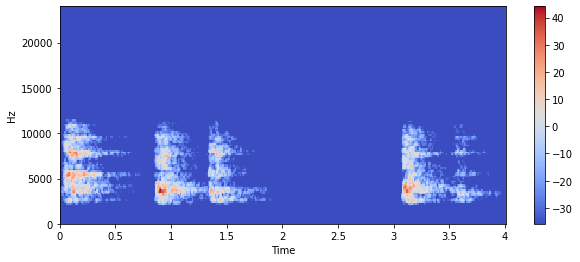

In [ ]:
# Mel spectrogram visualization
mel_db = librosa.amplitude_to_db(abs(mel))
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### 2.2.5) Cepstral representation (MFCC)
MFCC: Mel-Frequency Cepstral Coefficients

Il coefficiente MFCC si basa sulla descrizione di Fourier di uno spettrogramma di Mel (che, a sua volta, è stato ottenuto tramite l'analisi di Fourier)

Il risultato è una matrice bidimensionale:
  * La prima dimensione dipende dalla scelta delle frequenze/coefficienti.
  * La dimensione della seconda dimensione dipende dalla durata della traccia audio.

In [ ]:
# MFCC computation with default parameters
mfccs = mfcc(sd*1.0, sr=sr)

In [ ]:
# Shape of the resulting MFCC matrix
mfccs.shape

(20, 376)

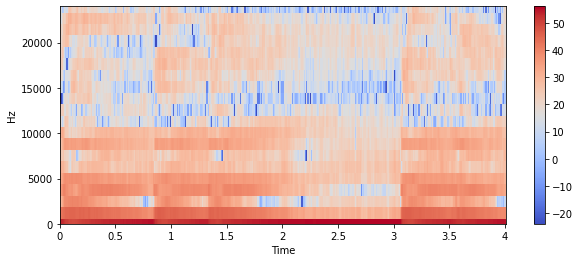

In [ ]:
# MFCC visualization
mfccs_db = librosa.amplitude_to_db(abs(mfccs))
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## 3) **Data Loader**

In questa sezione si definisce una funzione che permetta di caricare i dati ed estrarre le features.

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False): 

    labels = [] # labels list
    features = [] # features list

    for classe in sorted(os.listdir(base_path)):
      dir = base_path + classe + '/'

      for audio in sorted(os.listdir(dir)):
        path_audio = dir + audio
        
        if audio.endswith('.wav'): # se audio finisce con .wav
        # Load file and compute the requested features
          sound_data, sound_rate = librosa.load(path_audio, sr=None) # load audio
          cur_features = feature_extractor(sound_data, sound_rate) # estrazione feature
          features.append(cur_features) # impiliamo feature in una lista

          # Classes
          # Creiamo un'altra lista: la growth truth
          label = audio.split('-')[1] # estrae l'identificativo della classe 
          labels.append(label)

      # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=1, stratify=labels) 
      # stratify=labels (campionamento stratificato in base alle priori delle labels)
      # test_size=0.1 metti 0.1 nel test

    if normalize:
      eps = 0.001
      X_train = np.array(X_train)
      X_train_mean = X_train.mean(axis=0)
      X_train_std = X_train.std(axis=0)
      X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
      X_train = [row for row in X_train]

      X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

## 4) **Feautures**

### **Dichiarazione Features**

**Energia**

In [ ]:
# Energy
def energy(input, sound_rate=44100) :
  en = np.sum((input*1.0)**2, keepdims=True)
  return en

**Durata**

In [ ]:
# Duration
def duration(input, sound_rate=44100):
  d = input.shape
  d = np.asarray(d)*1.0
  return d

**Zero Crossing Rate** <br>
Questa funzione conta quante volte il segnale passa da positivo a negativo e da negativo a positivo.

Il mio approccio:

1. Rimuovere tutti i valori zero dai dati di ingresso. Questo è necessario per contare correttamente i cambiamenti di segno
2. Selezionare il segno di due unità consecutive del segnale: el1 ed el2
3. Se il prodotto tra el1 ed el2 è minore di 0, aggiungere a **zcr** la variabile 1, altrimenti non aggiungere nulla.
4. Procedere selezionando un'altra coppia di unità el1, el2.

In [ ]:
# Zero Crossing Rate
def zcr(input, sound_rate=44100):
  i = 0 
  zcr_ = 0

  input = input.tolist()
  input = [i for i in input if i != 0]
  while i < len(input)-1: # -1 because it has to take get to the penultimate value
    el1 = np.sign(input[i])
    el2 = np.sign(input[i+1])

    if el1*el2 < 0: # if multiplication is less than 0 there is sign change
      zcr_+=1
    i+=1

  zcr_ = np.asarray([zcr_*1.0])
  return zcr_

**Fourier Temporal Features**

In [ ]:
def feats_fourier(input, sound_rate=44100, size=10000):
    input_ft = np.real(rfft(input))
    # Remove any values exceeding the given limit
    output = input_ft[0:min(size, input_ft.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

**Spectrogram features**

In [ ]:
from scipy.signal import spectrogram

In [ ]:
def feats_spectrogram(input, sound_rate=44100, tsize=10):
  
  [spec_freqs, spec_times, spec] = spectrogram(input, fs=sound_rate)  
  spec = spec[:, 0:min(tsize, spec.shape[1])]
  spec = np.pad(spec, (0,(tsize-spec.shape[1])), 'constant')
  spec = spec[0:129,:] # check for number of columns
  spec = spec.flatten()

  return spec

**Mel Spectrogram**

In [ ]:
def feats_mel(input, sound_rate=44100, tsize=10):

  mel = librosa.feature.melspectrogram(y=input*1.0, sr=sound_rate)
  mel = mel[:, 0:min(tsize, mel.shape[1])]
  mel = np.pad(mel, (0,(tsize-mel.shape[1])), 'constant')
  mel = mel[0:128,:]
  mel = mel.flatten()
  
  return mel

**MFCC: Mel-Frequency Cepstral Coefficients**

In [ ]:
def feats_mfcc(input, sound_rate=44100, tsize=10):

  mfccs = librosa.feature.mfcc(input*1.0, sr=sound_rate)
  mfccs = mfccs[:, 0:min(tsize, mfccs.shape[1])]
  mfccs = np.pad(mfccs, (0,(tsize-mfccs.shape[1])), 'constant')
  mfccs = mfccs[0:20,:]
  mfccs = mfccs.flatten()
  
  return mfccs

**Combo**

In questa funzione si decide di creare due combinazioni:

* `Combo 1`: energia + durata
* `Combo 2`: energia + durata + zero crossing rate

In [ ]:
def combo1(input, sound_rate=44100):
  return np.concatenate((energy(input, sound_rate=44100), duration(input, sound_rate=44100)))

def combo2(input, sound_rate=44100):
  return np.concatenate((energy(input, sound_rate=44100), duration(input, sound_rate=44100), zcr(input, sound_rate=44100)))

### **4.1 Prove con 1 file audio**

In [ ]:
path_audio = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/children_playing/100263-2-0-126.wav'
path_audio

'/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/children_playing/100263-2-0-126.wav'

In [ ]:
sound_data, sound_rate = librosa.load(path_audio, sr=None)
sound_data.shape, sound_rate

((176400,), 44100)

In [ ]:
# Energy 
en = energy(sound_data, sound_rate=4410)
print(f'Energy: {en}, {type(en)}')

Energy: [4.408776], <class 'numpy.ndarray'>


In [ ]:
# Duration audio 
d = duration(sound_data, sound_rate=4410)
print(f'Duration: {d}, {type(d)}')

Duration: [176400.], <class 'numpy.ndarray'>


In [ ]:
# Zero Crossing Rate 
zcr_ = zcr(sound_data, sound_rate=4410)
print(f'Zero Crossing Rate {zcr_}')

Zero Crossing Rate [12823.]


In [ ]:
type(zcr_)

In [ ]:
# Fourier
f = feats_fourier(sound_data, sound_rate=4410)
print(f'Temporal Fourier: {f}')
print(f'Temporal Fourier type: {type(f)}')

Temporal Fourier: [-13.06814575   1.75040507   3.61157918 ...  -5.33165741   5.48601007
  -1.61350393]
Temporal Fourier type: <class 'numpy.ndarray'>


In [ ]:
# Spectrogram
spec = feats_spectrogram(sound_data, sound_rate=4410)
spec.shape, type(spec)

((1290,), numpy.ndarray)

In [ ]:
# Mel Spectrogram
# mel = feats_mel(sound_data, sound_rate=4410)
mel = feats_mel(sound_data, sound_rate=4410)
mel.shape, type(mel)

((1280,), numpy.ndarray)

In [ ]:
# Mel-Frequency Cepstral Coefficients
mfcc = feats_mfcc(sound_data, sound_rate=4410)
# mfcc = librosa.feature.mfcc(sound_data, sr=4410)
mfcc.shape, type(mfcc)

((200,), numpy.ndarray)

In [ ]:
# combo 1
c1 = combo1(sound_data, sound_rate=44100)
c1.shape, type(c1)

In [ ]:
# combo 2
c2 = combo2(sound_data, sound_rate=44100)
c2.shape, type(c2)

## 5) **Creazione Dataset**

In questa sezione si crano i dataset di training e validation da utilizzare nello step successivo della classificazione.

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_zcr_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_zcr_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_zcr_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_zcr_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=energy)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_en_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_en_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_en_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_en_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=duration)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_d_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_d_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_d_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_d_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_spectrogram)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_spec_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_spec_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_spec_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_spec_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mel)

/usr/local/lib/python3.8/dist-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_mel_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_mel_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_mel_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_mel_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc)

/usr/local/lib/python3.8/dist-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_mfcc_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_mfcc_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_mfcc_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_mfcc_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo1, normalize=True)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo1_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo1_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo1_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo1_big', y_test)

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo2_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo2_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo2_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo2_big', y_test)

## 6) **Data Augmentation + Organizzazione dati**

In questa sezione vengono definiti, ed eseguiti alcune tecniche di data augmentation. In particolare si decide di produrre due nuove tracce audio, una aumentando la velocità e l'altra diminuendola. 

In [ ]:
# Funzione per rendere gli audio tutti alla stessa lunghezza
def check_length(input, size): 
    output = input[0:min(size, input.shape[0])]
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [ ]:
def make_augmentation(path_audio, sound_rate = 44100):
    sound_data, sound_rate = librosa.load(path_audio, sr=None)
    fast_data = librosa.effects.time_stretch(sound_data, 1.5) # velocizzazione dell'audio
    slow_data = librosa.effects.time_stretch(sound_data, 0.5) # rallentamento dell'audio
    return check_length(fast_data, 2*sound_rate), check_length(slow_data, 2*sound_rate)

Si crea una nuova cartella **UrbanSound8K_aug** nel quale immagazzinare la traccia audio e le due nuove create dopo il processo di data augmentation.

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'
dst_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_aug/'

In [ ]:
for fold in os.listdir(base_path):

  src_path = base_path + fold + '/'

  for i, audio in enumerate(os.listdir(src_path)):

    dir = src_path + audio # directory corrente dell'audio
    dst = dst_path + fold + '/'
    dst_audio = dst_path + fold + '/' + audio # destination audio
    name_audio = audio.split('.')[0]

    fast_data, slow_data = make_augmentation(path_audio, sound_rate=44100) # controllare bene cosa esce
    path_fast_data = dst + name_audio + '_ft.wav'
    path_slow_data = dst + name_audio + '_sd.wav'

    if (os.path.exists(dst)): # se la cartella esiste --> aggiungi il file
      shutil.copyfile(dir, dst_audio)
      wav.write(path_fast_data, rate=44100, data=fast_data)
      wav.write(path_slow_data, rate=44100, data=slow_data)

    if not os.path.exists(dst): # se la cartella non esiste --> creala --> aggiungi il file
      os.makedirs(dst)
      shutil.copyfile(dir, dst_audio)
      wav.write(path_slow_data, rate=44100, data=slow_data)

## 7) **SVM Classification**

In questa sezione si effettua la classificazione di audio mediante il classificatore **SVM - Support Vector Machine**.

Si definisce la funzione evaluate_prediction che calcola e visualizza graficamente le metriche sulle predizioni.

In [ ]:
def evaluate_prediction(y_test, y_pred):
  
  classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Classification report
  cl = classification_report(y_test, y_pred, target_names = classes) 
  print('\nClassification Report\n', cl)
  print('\n')

  # Abbellimento confusion matrix
  ax = plt.subplot()
  # Heatmap della confuzion matrix 
  sns.heatmap(cm, annot=True, fmt='g', cmap = 'PuRd')

  ax.set_title('Confusion Matrix');

  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');  

  ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);

### 6.1) **Zcr**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_zcr_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_zcr_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_zcr_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_zcr_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 139.990s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1
 gamma: 0.005



Classification Report
               precision    recall  f1-score   support

           0       0.24      0.20      0.22       250
           1       0.11      0.19      0.14       107
           2       0.18      0.14      0.16       250
           3       0.13      0.10      0.11       250
           4       0.37      0.43      0.40       250
           5       0.20      0.17      0.18       250
           6       0.10      0.27      0.15        94
           7       0.23      0.16      0.19       250
           8       0.24      0.24      0.24       232
           9       0.15      0.15      0.15       250

    accuracy                           0.20      2183
   macro avg       0.20      0.21      0.19      2183
weighted avg       0.21      0.20      0.20      2183





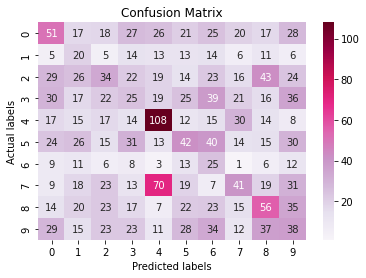

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.2) **Energy**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_en_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_en_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_en_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_en_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 249.169s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1
 gamma: 0.01



Classification Report
               precision    recall  f1-score   support

           0       0.25      0.30      0.27       250
           1       0.04      0.06      0.05       107
           2       0.20      0.37      0.26       250
           3       0.13      0.06      0.08       250
           4       0.15      0.13      0.14       250
           5       0.20      0.20      0.20       250
           6       0.04      0.06      0.05        94
           7       0.20      0.25      0.22       250
           8       0.44      0.21      0.28       232
           9       0.11      0.06      0.08       250

    accuracy                           0.18      2183
   macro avg       0.18      0.17      0.16      2183
weighted avg       0.19      0.18      0.18      2183





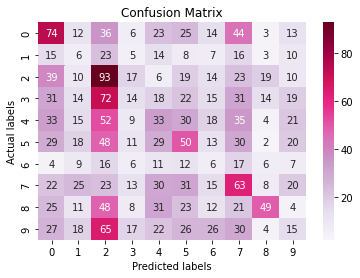

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.3) **Duration**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_d_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_d_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_d_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_d_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 115.770s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1
 gamma: 1.0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
               precision    recall  f1-score   support

           0       0.15      0.66      0.24       250
           1       0.34      0.10      0.16       107
           2       0.00      0.00      0.00       250
           3       0.41      0.04      0.07       250
           4       0.62      0.06      0.11       250
           5       0.00      0.00      0.00       250
           6       0.27      0.86      0.41        94
           7       0.44      0.20      0.28       250
           8       0.19      0.44      0.26       232
           9       0.57      0.05      0.10       250

    accuracy                           0.20      2183
   macro avg       0.30      0.24      0.16      2183
weighted avg       0.30      0.20      0.14      2183





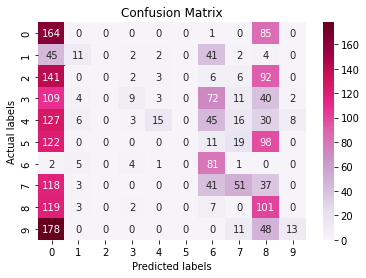

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.4) **Spectrogram**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_spec_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_spec_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_spec_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_spec_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 2301.305s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 12
 gamma: 0.01


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       250
           4       0.00      0.00      0.00       250
           5       0.00      0.00      0.00       250
           6       0.00      0.00      0.00        94
           7       0.11      1.00      0.21       250
           8       0.00      0.00      0.00       232
           9       0.00      0.00      0.00       250

    accuracy                           0.11      2183
   macro avg       0.01      0.10      0.02      2183
weighted avg       0.01      0.11      0.02      2183





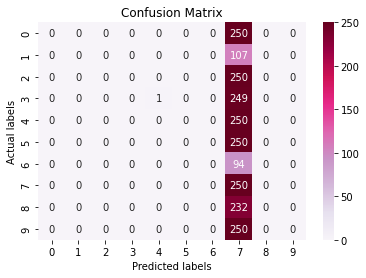

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.5) **Mel Spectrogram**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_mel_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_mel_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_mel_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_mel_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 2183.270s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 12
 gamma: 0.005



Classification Report
               precision    recall  f1-score   support

           0       0.44      0.24      0.31       250
           1       0.56      0.08      0.15       107
           2       0.31      0.18      0.23       250
           3       0.29      0.39      0.33       250
           4       0.69      0.22      0.33       250
           5       0.16      0.79      0.26       250
           6       1.00      0.02      0.04        94
           7       0.54      0.24      0.33       250
           8       0.51      0.10      0.17       232
           9       0.35      0.06      0.10       250

    accuracy                           0.26      2183
   macro avg       0.48      0.23      0.23      2183
weighted avg       0.44      0.26      0.24      2183





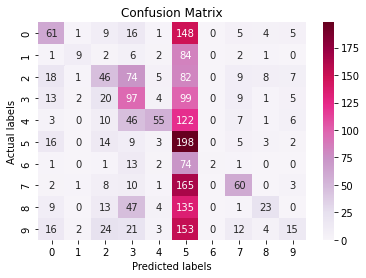

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.6) **Mel frequency Spectral Coefficient**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_mfcc_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_mfcc_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_mfcc_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_mfcc_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 566.144s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 5
 gamma: 0.1


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       250
           1       0.00      0.00      0.00       107
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       250
           4       1.00      0.14      0.25       250
           5       1.00      0.32      0.49       250
           6       1.00      0.02      0.04        94
           7       0.00      0.00      0.00       250
           8       0.00      0.00      0.00       232
           9       0.12      1.00      0.22       250

    accuracy                           0.17      2183
   macro avg       0.31      0.15      0.10      2183
weighted avg       0.29      0.17      0.11      2183





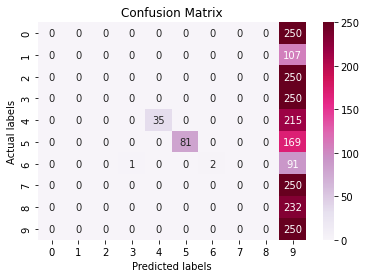

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.7) **Combo 1**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo1_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo1_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo1_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo1_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 150.334s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 500
 gamma: 1.0



Classification Report
               precision    recall  f1-score   support

           0       0.29      0.15      0.20       250
           1       0.30      0.37      0.33       107
           2       0.24      0.64      0.35       250
           3       0.21      0.02      0.04       250
           4       0.21      0.17      0.19       250
           5       0.29      0.28      0.29       250
           6       0.28      0.82      0.41        94
           7       0.30      0.53      0.38       250
           8       0.42      0.09      0.14       232
           9       0.50      0.00      0.01       250

    accuracy                           0.27      2183
   macro avg       0.30      0.31      0.23      2183
weighted avg       0.30      0.27      0.22      2183





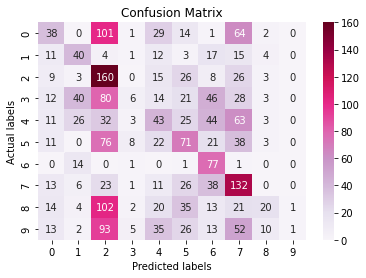

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 6.8) **Combo 2**

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo2_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo2_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo2_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo2_big.npy')

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 134.453s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 1.0



Classification Report
               precision    recall  f1-score   support

           0       0.38      0.53      0.44       250
           1       0.23      0.66      0.34       107
           2       0.29      0.47      0.36       250
           3       0.29      0.06      0.10       250
           4       0.77      0.44      0.56       250
           5       0.72      0.39      0.51       250
           6       0.41      0.77      0.53        94
           7       0.57      0.50      0.54       250
           8       0.44      0.47      0.46       232
           9       0.32      0.19      0.24       250

    accuracy                           0.41      2183
   macro avg       0.44      0.45      0.41      2183
weighted avg       0.46      0.41      0.40      2183





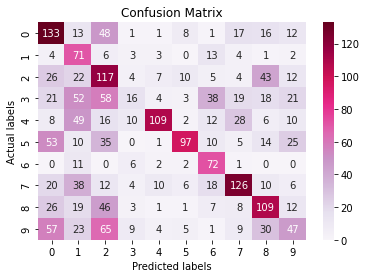

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

Il risultato migliore si con SVM si ottiene utilizzando come features la combinazione di energia, durata e zero crossing rate.

## 8) **SVM Classification Data Augmentation**

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_augmented/'

### 8.1) **Data Loader**

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False): 

    labels = [] # labels list
    features = [] # features list

    for classe in sorted(os.listdir(base_path)):
      dir = base_path + classe + '/'

      for audio in sorted(os.listdir(dir)):
        path_audio = dir + audio
        
        if audio.endswith('.wav'): # se audio finisce con .wav
        # Load file and compute the requested features
          sound_data, sound_rate = librosa.load(path_audio, sr=None) # load audio
          cur_features = feature_extractor(sound_data, sound_rate) # estrazione feature
          features.append(cur_features) # impiliamo feature in una lista

          # Classes
          # Creiamo un'altra lista: la growth truth
          label = audio.split('-')[1] # estrae l'identificativo della classe 
          labels.append(label)

      # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=1, stratify=labels) 
      # stratify=labels (campionamento stratificato in base alle priori delle labels)
      # test_size=0.1 metti 0.1 nel test

    if normalize:
      eps = 0.001
      X_train = np.array(X_train)
      X_train_mean = X_train.mean(axis=0)
      X_train_std = X_train.std(axis=0)
      X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
      X_train = [row for row in X_train]

      X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

### 8.2) **Combo 2**

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo2, normalize=True)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo2_aug', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo2_aug', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo2_aug', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo2_aug', y_test)

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_combo2_aug.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_combo2_aug.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_combo2_aug.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_combo2_aug.npy')

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(19639, 6547, 19639, 6547)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 1566.150s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 1.0



Classification Report
               precision    recall  f1-score   support

           0       0.47      0.15      0.23       750
           1       0.25      0.16      0.19       321
           2       0.38      0.17      0.23       750
           3       0.31      0.04      0.07       750
           4       0.15      0.47      0.23       750
           5       0.68      0.20      0.31       750
           6       0.06      0.52      0.11       280
           7       0.50      0.19      0.27       750
           8       0.46      0.18      0.26       696
           9       0.30      0.09      0.13       750

    accuracy                           0.20      6547
   macro avg       0.36      0.22      0.20      6547
weighted avg       0.38      0.20      0.21      6547





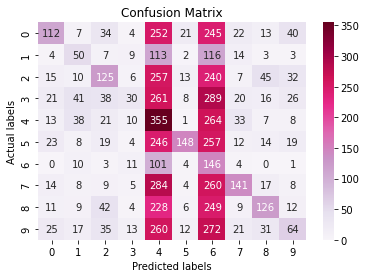

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

### 8.3) **Zcr**

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=zcr, normalize=True)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_zcr_aug', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_zcr_aug', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_zcr_aug', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_zcr_aug', y_test)

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_zcr_aug.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_zcr_aug.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_zcr_aug.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_zcr_aug.npy')

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(19639, 6547, 19639, 6547)

In [ ]:
# Parameters to be tested in cross-validation
param_grid = {'C': [1, 5, 10, 12, 15, 18, 20, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 1523.170s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+ str(clf.best_estimator_.C))
print(' gamma: '+ str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
               precision    recall  f1-score   support

           0       0.50      0.00      0.00       750
           1       0.14      0.05      0.07       321
           2       0.23      0.07      0.11       750
           3       1.00      0.00      0.00       750
           4       0.55      0.11      0.19       750
           5       0.00      0.00      0.00       750
           6       0.13      0.23      0.17       280
           7       0.48      0.08      0.13       750
           8       0.23      0.21      0.22       696
           9       0.13      0.82      0.22       750

    accuracy                           0.16      6547
   macro avg       0.34      0.16      0.11      6547
weighted avg       0.37      0.16      0.11      6547





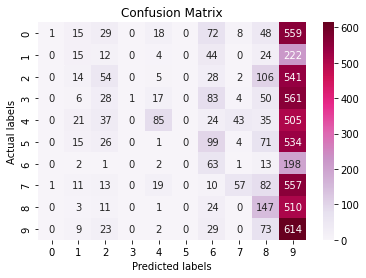

In [ ]:
y_pred = clf.predict(X_test)
evaluate_prediction(y_test, y_pred)

## 9) **Mel Spectrogram Images**

In [ ]:
def mel_spec(input, sound_rate=44100):
  mels = np.mean(librosa.feature.melspectrogram(y=input, sr=sound_rate).T,axis=0) 
  return mels

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'

In [ ]:
# Load and split data using zcr as feature extractor
X_train, X_test, y_train, y_test = load_data(feature_extractor=mel_spec)

In [ ]:
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_melspec_big', X_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_melspec_big', X_test)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_melspec_big', y_train)
np.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_melspec_big', y_test)

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_train_melspec_big.npy')
X_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/X_test_melspec_big.npy')
y_train = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_train_melspec_big.npy')
y_test = np.load('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Dataset/y_test_melspec_big.npy')

In [ ]:
X_train.shape, type(X_train), X_train.dtype

((6549, 128), numpy.ndarray, dtype('float32'))

In [ ]:
X_train.shape, X_test.shape

((6549, 128), (2183, 128))

In [ ]:
Y_train_cat = to_categorical(y_train)
Y_test_cat = to_categorical(y_test)
Y_train_cat.shape, Y_test_cat.shape

((6549, 10), (2183, 10))

In [ ]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [ ]:
input_dim = (16, 8, 1)
num_classes = 10

### 9.1) **Model 1**

In [ ]:
sound_data, sound_rate = librosa.load(path_audio, sr=None)
sound_data.shape, sound_rate

((192000,), 48000)

In [ ]:
mel_spec(sound_data, sound_rate=sound_rate).shape

(128,)

In [ ]:
# Network Architecture
model = keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation = "tanh"))
model.add(tf.keras.layers.Dense(256, activation = "tanh"))
model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
# Network compilation
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Fitting
history=model.fit(X_train, Y_train_cat, epochs = 100, batch_size = 64, validation_data = (X_test, Y_test_cat))

Epoch 1/100
103/103 [==============================] - 16s 15ms/step - loss: 1.5641 - accuracy: 0.4572 - val_loss: 1.3298 - val_accuracy: 0.5502
Epoch 2/100
103/103 [==============================] - 1s 9ms/step - loss: 1.2075 - accuracy: 0.5850 - val_loss: 1.1327 - val_accuracy: 0.6093
Epoch 3/100
103/103 [==============================] - 1s 8ms/step - loss: 1.0221 - accuracy: 0.6529 - val_loss: 1.0811 - val_accuracy: 0.6299
Epoch 4/100
103/103 [==============================] - 1s 8ms/step - loss: 0.8973 - accuracy: 0.7036 - val_loss: 1.0313 - val_accuracy: 0.6734
Epoch 5/100
103/103 [==============================] - 1s 8ms/step - loss: 0.8277 - accuracy: 0.7219 - val_loss: 0.9273 - val_accuracy: 0.6926
Epoch 6/100
103/103 [==============================] - 1s 8ms/step - loss: 0.7301 - accuracy: 0.7552 - val_loss: 0.9060 - val_accuracy: 0.7151
Epoch 7/100
103/103 [==============================] - 1s 7ms/step - loss: 0.6642 - accuracy: 0.7725 - val_loss: 0.9471 - val_accuracy: 0.71

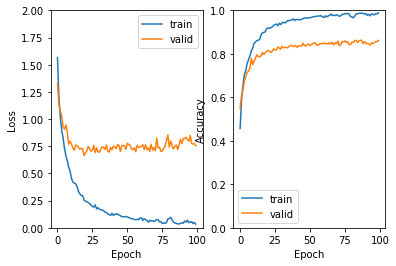

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
model.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/model1_melspec.h5')

### 9.2) **Model 2**

In [ ]:
# Network Architecture
model = keras.Sequential()

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation = "tanh"))
model.add(tf.keras.layers.Dense(128, activation = "tanh"))
model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

In [ ]:
# Network compilation
model.compile(optimizer = 'Adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Fitting
history=model.fit(X_train, Y_train_cat, epochs = 40, batch_size = 64, validation_data = (X_test, Y_test_cat))

Epoch 1/40
103/103 [==============================] - 4s 11ms/step - loss: 1.7152 - accuracy: 0.3959 - val_loss: 1.9918 - val_accuracy: 0.3454
Epoch 2/40
103/103 [==============================] - 1s 7ms/step - loss: 1.3127 - accuracy: 0.5561 - val_loss: 2.0428 - val_accuracy: 0.3683
Epoch 3/40
103/103 [==============================] - 1s 7ms/step - loss: 1.1362 - accuracy: 0.6193 - val_loss: 1.5559 - val_accuracy: 0.5208
Epoch 4/40
103/103 [==============================] - 1s 7ms/step - loss: 0.9874 - accuracy: 0.6659 - val_loss: 1.2868 - val_accuracy: 0.5653
Epoch 5/40
103/103 [==============================] - 1s 5ms/step - loss: 0.8860 - accuracy: 0.6971 - val_loss: 1.0505 - val_accuracy: 0.6679
Epoch 6/40
103/103 [==============================] - 1s 6ms/step - loss: 0.8031 - accuracy: 0.7248 - val_loss: 0.9368 - val_accuracy: 0.6972
Epoch 7/40
103/103 [==============================] - 1s 6ms/step - loss: 0.7308 - accuracy: 0.7561 - val_loss: 0.8636 - val_accuracy: 0.7201
Epoch

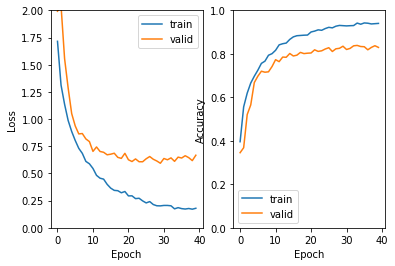

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
model.save('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/model2_melspec.h5')

## 10) **Demo**

In [ ]:
path_audio = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/street_music/101848-9-0-3.wav'

In [ ]:
# Import file
sound_data, sound_rate = librosa.load(path_audio, sr=None)
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

In [ ]:
def mel_spec(input, sound_rate=44100):
  mels = np.mean(librosa.feature.melspectrogram(y=input, sr=sound_rate).T,axis=0) 
  return mels

In [ ]:
# Mel spectrogram
melspec_audio = mel_spec(sound_data)
melspec_audio.shape
# Reshape
x = melspec_audio.reshape(16, 8, 1)
x = np.expand_dims(x, 0)
x.shape

(1, 16, 8, 1)

In [ ]:
model = load_model('/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/model1_melspec.h5')

In [ ]:
pred = model.predict(x)
print(f'101848-9-0-3.wav appartiene alla classe: {np.argmax(pred)}')

1/1 [==============================] - 0s 25ms/step
101848-9-0-3.wav appartiene alla classe: 9


# **Spectrogram Images**

### 1. Data generation + Organization

In [ ]:
path_audio = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/dog_bark/196127-3-0-0.wav'

In [ ]:
sd, sr = librosa.load(path_audio, sr=None)
print(f'Sound data of audio 196127-3-0-0.wav is: {sd.shape}')
print(f'Sound rate of audio 196127-3-0-0.wav is: {sr}')

Sound data of audio 196127-3-0-0.wav is: (192000,)
Sound rate of audio 196127-3-0-0.wav is: 48000


In [ ]:
melspec = melspectrogram(sd, sr)
melspec.shape

(128, 376)

In [ ]:
[spec_freqs, spec_times, spec] = spectrogram(sd, fs=sr) 

In [ ]:
spec.shape

(129, 857)

In [ ]:
image = spec/np.max(spec)*255

In [ ]:
image.shape

(129, 857)

In [ ]:
if image.min() < 0:
  print('yes')

In [ ]:
image = np.repeat(np.expand_dims(image, 2), 3, 2).astype('uint8')

In [ ]:
image.shape, image.max(), image.min(), type(image), image.dtype

((129, 857, 3), 255, 0, numpy.ndarray, dtype('uint8'))

In [ ]:
import soundfile as sf 

In [ ]:
def get_spectrogram(path, output_shape = (128, 128)):

  sound_data, sound_rate = librosa.load(path_audio, sr=None)
  # data, samplerate = sf.read(path)

  # Spettrogramma
  [spec_freqs, spec_times, spec] = spectrogram(sound_data, fs=sound_rate) 
  image = spec/np.max(spec)*255

  # Espansione dell'immagine a tre dimensioni
  image = np.repeat(np.expand_dims(image, 2), 3, 2).astype('uint8')

  #image = cv2.resize(image, output_shape)

  return image

In [ ]:
image = get_spectrogram(path_audio, (256,256))

In [ ]:
image.shape

(129, 857, 3)

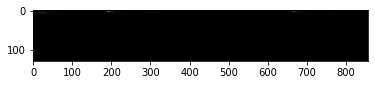

In [ ]:
plt.imshow(image)

In [ ]:
dest = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/prova.jpg'

In [ ]:
cv2.imwrite(dest, image)

True

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/UrbanSound8K_fin/'
# Valutare se mettere UrbanSound8K_reduced

In [ ]:
dst_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Spectrogram_images/'

In [ ]:
for fold in os.listdir(base_path):

  src_path = base_path + fold + '/'

  for i, audio in enumerate(os.listdir(src_path)):

    dir = src_path + audio
    dst = dst_path + fold + '/' 
    
    audio = audio.split('.')[0]
    name = audio + '.jpg'
    dst_im = dst + name

    image = get_spectrogram(dir, output_shape = (256, 256)) # controllare bene cosa esce

    if (os.path.exists(dst)): # se la cartella esiste --> aggiungi il file
      cv2.imwrite(dst_im, image)

    if not os.path.exists(dst): # se la cartella non esiste --> creala --> aggiungi il file
      os.makedirs(dst)
      cv2.imwrite(dst_im, image)

In [ ]:
sound_classes=os.listdir(base_path)
print(sound_classes)

['dog_bark', 'drilling', 'jackhammer', 'street_music', 'children_playing', 'enginge_idling', 'siren', 'gun_shot', 'air_conditioner', 'car_horn']


In [ ]:
i

1000

### 2. **Preprocessing** and **Splitting into Training and Validation**

In [ ]:
base_path = '/content/gdrive/MyDrive/DSIM Project/UNI-DIMENSIONAL/Spectrogram_images/'

In [ ]:
# Training dataset: standardization 
train_datagen = ImageDataGenerator(
                                   validation_split=0.1)

In [ ]:
validation_datagen = ImageDataGenerator(
                                   validation_split=0.1)

In [ ]:
# Training data loader
train_set = train_datagen.flow_from_directory(base_path,
                                              target_size=(128,128),
                                              color_mode='rgb',
                                              batch_size=64,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True,
                                              seed=1)                                                                    


Found 7861 images belonging to 10 classes.


In [ ]:
# Validation data loader
val_set = validation_datagen.flow_from_directory(base_path,
                                                target_size=(128,128),
                                                color_mode='rgb',
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=False,
                                                seed=1) 

Found 871 images belonging to 10 classes.


In [ ]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 128, 128, 3)
(64, 10)


### 3. Classification

In [ ]:
num_classes = 10

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Model Architecture

inputs = keras.Input((128, 128, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 43, 43, 64)        18496 

In [ ]:
# Model compilazione
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model_history = model.fit(train_set, 
                          epochs = 60,
                          validation_data = val_set,
                          verbose = 1)

In [ ]:
resume_model_history(model_history)

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and Validation Accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
sound_classes=os.listdir(base_path)
print(sound_classes)

In [ ]:
Y_pred = model.predict(val_set)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(val_set.classes, y_pred, target_names=sound_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1